# COL3A1

The [COL3A1](https://www.omim.org/entry/120180) gene encodes the collagen alpha-1 (III) chain. Three of these chains can multimerize to form type III collagen, a major component of the extracellular matrix of elastic tissues like dermis, vasculature and hollow organs for which it provides structural support and is involved in processes like wound healing, angiogenesis, development and cell differentiation. Binding partners of COL3A1 are cell surface receptors, other collagens (I & IV), fibronectin and proteoglycans ([Omar R, et al. Matrix Biol Plus. 2021](https://pubmed.ncbi.nlm.nih.gov/34849481/)).
At least in mice expression of Col3a1 is also found in the developing, but not the adult brain and liver ([Kuivaniemi H, et al. Gene. 2019](https://pubmed.ncbi.nlm.nih.gov/31075413/)).

After gene expression the N-terminal signal peptide (nt118-189) is cleaved off of the preproprotein to generate the proprotein. The C-terminal propeptide (nt3781-4515) induces homotrimerization, stabilized by disulfide bonds (AA1196, 1197). The multimerized proprotein again undergoes cleavage of the N-terminal (nt190-577) and C-terminal propeptide, giving rise to the mature protein. The mature protein consists of a stretch of uninterrupted repeats of a Glycin-X-Y motif (where X and Y are often Proline of Hydroxyproline; nt619-3705) flanked by N-terminal (nt577-618) and C-terminal (nt3706-3780) telopeptides. The Glycin-X-Y stretch in each chain folds into a left-handed helix and the three chains are then wrapped together into a right-handed super-helix which is crosslinked to other collagens via Lysine-links (AA110, 193; [Kuivaniemi H, et al. Gene. 2019](https://pubmed.ncbi.nlm.nih.gov/31075413/), [Parkin JD, et al. PLoS One. 2017](https://pubmed.ncbi.nlm.nih.gov/28704418/)). 

OMIM distinguishes two different disorders associated with germline variants in COL3A1, which are inherited in an autosomally-dominant and autosomally-recessive fashion respectively:
1. [Vascular Ehlers-Danlos syndrome (vEDS/ EDSVASC)](https://www.omim.org/clinicalSynopsis/130050): characterized by only mild joint hyper-mobility and skin hyper-flexibility, but thin skin with visible veins, and characteristic facial features (thin lips and nose, lobeless ears) and complicated by ruptures of vasculature and hollow organs. Inherited autosomally-dominant.
2. [Polymicrogyria (with or with vEDS; PMGEDSV)](https://www.omim.org/clinicalSynopsis/618343): characterized by polymicrogyria and other structural brain defects, but only variable amounts of developmental delay/ intellectual disability & seizures and also variable amounts of vEDS-typical features. Inherited autosomally-recessive.

Several previous publications have reported candidate genotype-phenotype correlations on the COL3A1 gene.

<ol>
<li>Reviewing the literature [Kuivaniemi H, et al. Gene. 2019](https://pubmed.ncbi.nlm.nih.gov/31075413/) propose, that monoallelic variants lead to vEDS, while biallelic variants lead to a phenotype involving polymicrogyria. </li>
<li>he same authors further propose, that male vEDS patients are more frequently affected by vascular events compared to female patients. </li>
<li>[Pepin MG, et al.  Genet Med. 2014](https://pubmed.ncbi.nlm.nih.gov/24922459/) suggest, that heterozygous null mutations show an overall better survival than  missense mutations and splice mutations. Splice mutations show the shortest median survival.  [Frank M, et al. Eur J Hum Genet. 2015](https://pubmed.ncbi.nlm.nih.gov/25758994/) show a very similiar effect but on the age of onset. </li>
</ol>

While [Kuivaniemi H, et al. Gene. 2019](https://pubmed.ncbi.nlm.nih.gov/31075413/) don´t apply formal statistical testing to the data, [Frank M, et al. Eur J Hum Genet. 2015](https://pubmed.ncbi.nlm.nih.gov/25758994/) use a log rank test and [Pepin MG, et al.  Genet Med. 2014](https://pubmed.ncbi.nlm.nih.gov/24922459/) employ Cox regression.

Therefor we tested the influence of mono- and bi-allelic mutations on the occurence of polymicrogyria, the influence of sex on the occurrence of vascular events and the influence of null-mutations against missense mutations and splice mutations on the onset of signs of vEDS.

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using genophenocorr version {gpsea.__version__}")

Loaded HPO v2025-01-16
Using genophenocorr version 0.9.4


# COL3A1
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for COL3A1.

In [2]:
gene_symbol = 'COL3A1'
mane_tx_id = 'NM_000090.4'
mane_protein_id = "NP_000081.2" # collagen alpha-1(III) chain preproprotein

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

from ppktstore.registry import configure_phenopacket_registry
phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.23") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)

validation.summarize()

Individuals Processed: 100%|██████████| 41/41 [00:00<00:00, 52.55 individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer
cv = CohortViewer(hpo=hpo)
cv.process(cohort=cohort, transcript_id=mane_tx_id)

n,HPO Term
29,Bruising susceptibility
25,Dermal translucency
19,Finger joint hypermobility
14,Spontaneous pneumothorax
12,Arterial rupture
11,Arterial dissection
9,Gingival fragility
7,Aortic dissection
6,Talipes equinovarus
6,Polymicrogyria


/var/folders/hq/zttr8hjx127fgvh0bq7h4bc80000gn/T/ipykernel_99270/3873260641.py:16: DeprecationWarning: draw_protein_diagram was deprecated and will be removed in `1.0.0`. Use `draw_protein` instead
  visualizer.draw_protein_diagram(


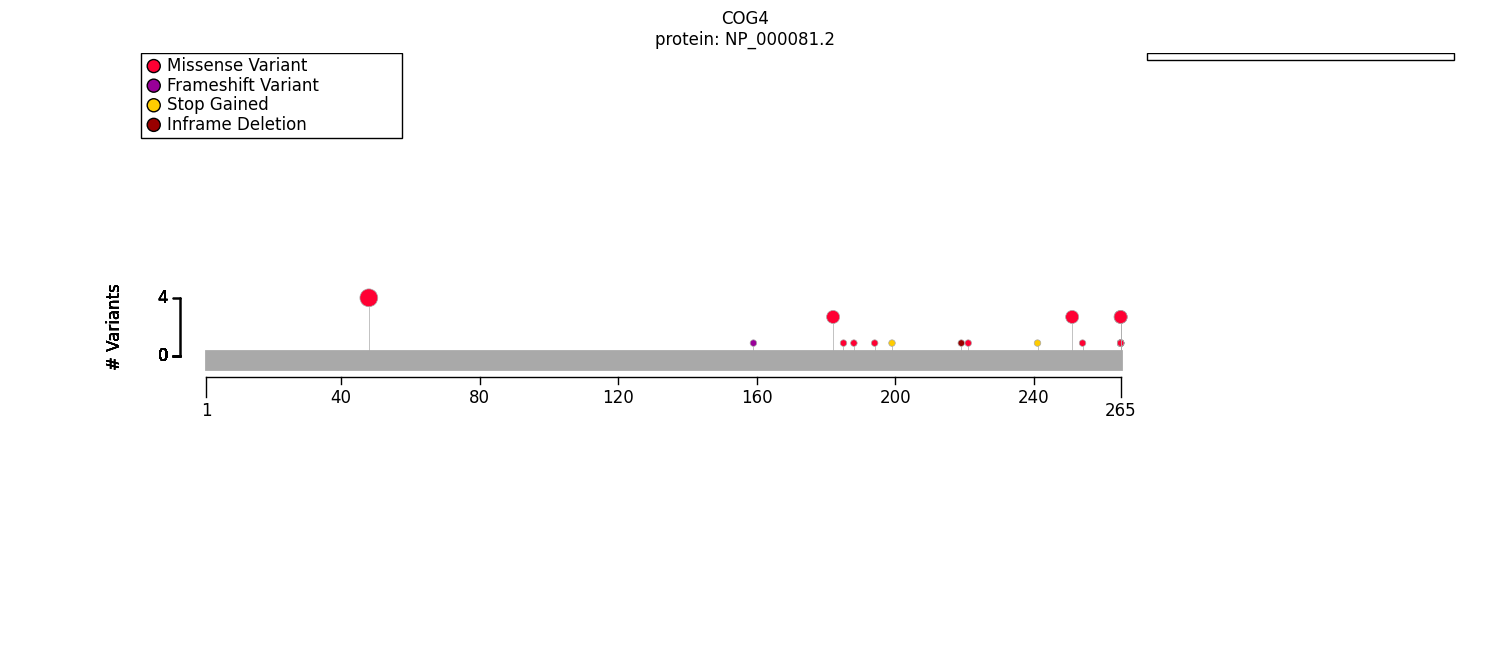

In [5]:
from gpsea.model.genome import GRCh38
from gpsea.model import ProteinMetadata
from gpsea.preprocessing import VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt
import pandas as pd
txc_service = VVMultiCoordinateService(genome_build=GRCh38)
tx_coordinates = txc_service.fetch(mane_tx_id)
features = []
df = pd.DataFrame(features, columns=["region","category","start", "end"])
protein_meta = ProteinMetadata.from_feature_frame(protein_id=mane_protein_id, label="COG4", features=df, protein_length=265)


COL3A1_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
COL3A1_fig.tight_layout()

In [6]:
from gpsea.view import CohortVariantViewer

viewer = CohortVariantViewer(tx_id=mane_tx_id)
viewer.process(cohort)

Count,Variant key,HGVS,Overlapping Exons,Effects
4,2_188984825_188984825_C_G,c.145C>G (p.Pro49Ala),2,missense
2,2_188988099_188988099_G_A,c.547G>A (p.Gly183Ser),6,missense
1,2_188990129_188990129_C_T,c.724C>T (p.Arg242Ter),9,stop gained
1,2_188989424_188989424_G_A,c.665G>A (p.Gly222Asp),8,missense
1,2_188998324_188998324_G_C,c.1977+5G>C (-),-,"splice donor 5th base, intronic"
1,2_188988605_188988605_C_T,c.598C>T (p.Gln200Ter),7,stop gained
1,2_188991533_188991533_T_G,c.897+2T>G (-),-,splice donor
1,2_188988108_188988108_G_A,c.556G>A (p.Gly186Ser),6,missense
1,2_188996179_188996179_G_A,c.1662+1G>A (-),-,splice donor
1,2_188989416_188989422_TGCTATA_T,c.659_664del (p.Ala220_Ile221del),8,inframe deletion


# Genotype-Phenotype Correlation (GPC) Analysis

In [7]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [8]:
from gpsea.model import VariantEffect
from gpsea.analysis.clf import monoallelic_classifier
from gpsea.analysis.predicate import variant_effect
from gpsea.view import MtcStatsViewer

is_missense = variant_effect(VariantEffect.MISSENSE_VARIANT, mane_tx_id)
missense_clf = monoallelic_classifier(
    a_predicate=is_missense,
    b_predicate=~is_missense,
    a_label='Missense', 
    b_label='Other'
)

missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)

mtc_viewer = MtcStatsViewer()
mtc_viewer.process(missense_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,77
HMF03,Skipping term because of a child term with the same individual counts,4
HMF08,Skipping general term,48
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,36


In [9]:
from gpsea.view import summarize_hpo_analysis
summarize_hpo_analysis(hpo, missense_result)

Allele group,Missense,Other,Corrected p values,p values
Gingival fragility [HP:0034518],3/19 (16%),6/12 (50%),0.674278,0.056190
Dermal translucency [HP:0010648],12/19 (63%),11/14 (79%),1.000000,0.455080
Bruising susceptibility [HP:0000978],15/20 (75%),12/14 (86%),1.000000,0.672174
Finger joint hypermobility [HP:0006094],10/19 (53%),9/14 (64%),1.000000,0.722801
Abnormal blood vessel morphology [HP:0033353],10/10 (100%),8/8 (100%),1.000000,1.000000
Small joint hypermobilty [HP:0430046],10/10 (100%),9/9 (100%),1.000000,1.000000
Abnormality of joint mobility [HP:0011729],10/10 (100%),9/9 (100%),1.000000,1.000000
Abnormality of hand joint mobility [HP:0006256],10/10 (100%),9/9 (100%),1.000000,1.000000
Abnormal finger morphology [HP:0001167],10/10 (100%),9/9 (100%),1.000000,1.000000
Abnormal appendicular skeleton morphology [HP:0011844],10/10 (100%),9/9 (100%),1.000000,1.000000


In [10]:
import gpsea.analysis.predicate
from gpsea.model.genome import Region
from gpsea.analysis.predicate import protein_region

is_triple = protein_region(region=Region(start=167, end=1196), tx_id=mane_tx_id)

triple_clf = monoallelic_classifier(
    a_predicate=is_triple,
    b_predicate=~is_triple,
    a_label='is_triple', 
    b_label='Other'
)

triple_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=triple_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo, triple_result)


Allele group,is_triple,Other,Corrected p values,p values
Dermal translucency [HP:0010648],15/24 (62%),8/9 (89%),1.0,0.216638
Finger joint hypermobility [HP:0006094],12/24 (50%),7/9 (78%),1.0,0.240922
Spontaneous pneumothorax [HP:0002108],9/26 (35%),5/9 (56%),1.0,0.431768
Bruising susceptibility [HP:0000978],19/25 (76%),8/9 (89%),1.0,0.644458
Small joint hypermobilty [HP:0430046],12/12 (100%),7/7 (100%),1.0,1.000000
Abnormality of joint mobility [HP:0011729],12/12 (100%),7/7 (100%),1.0,1.000000
Abnormality of hand joint mobility [HP:0006256],12/12 (100%),7/7 (100%),1.0,1.000000
Abnormal finger morphology [HP:0001167],12/12 (100%),7/7 (100%),1.0,1.000000
Abnormal appendicular skeleton morphology [HP:0011844],12/12 (100%),7/7 (100%),1.0,1.000000
Abnormal blood vessel morphology [HP:0033353],14/14 (100%),4/4 (100%),1.0,1.000000


In [11]:
from gpsea.analysis.clf import diagnosis_classifier

dx_clf = diagnosis_classifier(
    diagnoses=('OMIM:130050', 'OMIM:618343'),
    labels=('Ehlers-Danlos syndrome, vascular type', 'Polymicrogyria with or without vascular-type EDS'),
)
dx_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=dx_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo, dx_result)

Diagnosis,OMIM:130050,OMIM:618343,Corrected p values,p values
Small joint hypermobilty [HP:0430046],19/19 (100%),2/5 (40%),0.059289,0.004941
Finger joint hypermobility [HP:0006094],19/33 (58%),0/3 (0%),0.531291,0.095238
Dermal translucency [HP:0010648],23/33 (70%),2/6 (33%),0.531291,0.162585
Talipes equinovarus [HP:0001762],4/32 (12%),2/5 (40%),0.531291,0.177097
Bruising susceptibility [HP:0000978],27/34 (79%),2/4 (50%),0.558521,0.232717
Abnormal systemic arterial morphology [HP:0011004],16/16 (100%),1/1 (100%),1.000000,1.000000
Abnormal blood vessel morphology [HP:0033353],18/18 (100%),2/2 (100%),1.000000,1.000000
Abnormal finger morphology [HP:0001167],19/19 (100%),1/1 (100%),1.000000,1.000000
Abnormal appendicular skeleton morphology [HP:0011844],19/19 (100%),1/1 (100%),1.000000,1.000000
Joint hypermobility [HP:0001382],19/19 (100%),2/2 (100%),1.000000,1.000000


# Extend VariantPredicate class

This example shows how to extend the VariantPredicate class to create one's own predicate. In this case, we create a predicate to test for missense variants that affect glycine residues.

In [12]:
from gpsea.analysis.predicate import VariantPredicate, variant_effect
from gpsea.model import Variant, VariantEffect

class AffectsGlycineResidue(VariantPredicate):
    """
    Return True iff this variant is missense and the reference residue is Gylcine.
    """
    def __init__(self):
        super().__init__()

    def get_question(self) -> str:
        return self.description

    def test(self, variant: Variant) -> bool:
        """
        Test if the `variant` is a missense variant that affects a REF Gylcine residue

        Args:
            variant: an instance of :class:`~gpsea.model.Variant` to test.

        Returns:
            bool: `True` if the variant is a missense variant that affects a REF Gylcine residue
        """
        is_missense =  variant_effect(VariantEffect.MISSENSE_VARIANT, variant.get_preferred_tx_annotation().transcript_id)
        return is_missense.test(variant) and "p.Gly" in variant.get_preferred_tx_annotation().hgvsp
    
    def description(self) -> str:
        return self.__str__()
    
    def name(self) -> str:
        return self.__str__()
    
    def variable_name(self) -> str:
        return self.__str__()

    def __str__(self) -> str:
        return "Is Glycine Missense"
    
    def __repr__(self):
        return self.__str__()

In [13]:
is_gly_missense = AffectsGlycineResidue()
is_gly_missense_clf = monoallelic_classifier(
    a_predicate=is_gly_missense,
    b_predicate=~is_gly_missense,
    a_label='Gly missense', 
    b_label='Other'
)

is_gly_missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=is_gly_missense_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo, is_gly_missense_result)

Allele group,Gly missense,Other,Corrected p values,p values
Gingival fragility [HP:0034518],2/18 (11%),7/13 (54%),0.199433,0.016619
Dermal translucency [HP:0010648],11/18 (61%),12/15 (80%),1.000000,0.282799
Bruising susceptibility [HP:0000978],14/19 (74%),13/15 (87%),1.000000,0.426304
Finger joint hypermobility [HP:0006094],9/18 (50%),10/15 (67%),1.000000,0.482424
Abnormal blood vessel morphology [HP:0033353],10/10 (100%),8/8 (100%),1.000000,1.000000
Subcutaneous hemorrhage [HP:0001933],14/14 (100%),13/13 (100%),1.000000,1.000000
Spontaneous pneumothorax [HP:0002108],8/20 (40%),6/15 (40%),1.000000,1.000000
Small joint hypermobilty [HP:0430046],9/9 (100%),10/10 (100%),1.000000,1.000000
Abnormality of joint mobility [HP:0011729],9/9 (100%),10/10 (100%),1.000000,1.000000
Abnormality of hand joint mobility [HP:0006256],9/9 (100%),10/10 (100%),1.000000,1.000000


In [14]:
# Allele count - mono- vis biallelic COL3A1 variants

from gpsea.analysis.clf import allele_count
from gpsea.analysis.predicate import gene

affects_COL3A1 = gene(symbol=gene_symbol)

allelic_clf = allele_count(
    counts=(0, 1),
    target=affects_COL3A1,
)

allele_count_result = analysis.compare_genotype_vs_phenotypes(
    cohort = cohort,
    gt_clf = allelic_clf,
    pheno_clfs = pheno_clfs
)
summarize_hpo_analysis(hpo, allele_count_result)

Allele count,0 alleles,1 allele,Corrected p values,p values
Talipes equinovarus [HP:0001762],1/1 (100%),3/31 (10%),1.0,0.125
Spontaneous pneumothorax [HP:0002108],1/1 (100%),13/34 (38%),1.0,0.400
Small joint hypermobilty [HP:0430046],1/1 (100%),18/18 (100%),1.0,1.000
Abnormality of joint mobility [HP:0011729],1/1 (100%),18/18 (100%),1.0,1.000
Abnormality of hand joint mobility [HP:0006256],1/1 (100%),18/18 (100%),1.0,1.000
Abnormal finger morphology [HP:0001167],1/1 (100%),18/18 (100%),1.0,1.000
Abnormal appendicular skeleton morphology [HP:0011844],1/1 (100%),18/18 (100%),1.0,1.000
Finger joint hypermobility [HP:0006094],1/1 (100%),18/32 (56%),1.0,1.000
Dermal translucency [HP:0010648],1/1 (100%),22/32 (69%),1.0,1.000
Subcutaneous hemorrhage [HP:0001933],1/1 (100%),26/26 (100%),1.0,1.000


## Hypothesis:
Null variants show a later onset of symptoms than missense variants in vEDS. Note that because we are using a monoallelic classifier, biallelic cases will be omitted (sothe following tests will not include polymicrogyria).

In [15]:
from gpsea.analysis.temporal.endpoint import disease_onset
from gpsea.analysis.temporal.stats import LogRankTest
from gpsea.analysis.temporal import SurvivalAnalysis


disease = "OMIM:130050"  
endpoint = disease_onset(disease_id=disease)
is_missense = variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)

missense_clf = monoallelic_classifier(
    a_predicate=is_missense,
    b_predicate=~is_missense,
    a_label="missense", 
    b_label="other",
)

survival_statistic = LogRankTest()
survival_analysis = SurvivalAnalysis(
    statistic=survival_statistic,
)
missense_survival_result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_clf=missense_clf,
    endpoint=endpoint,
)
missense_survival_result.pval

0.31680904154835354

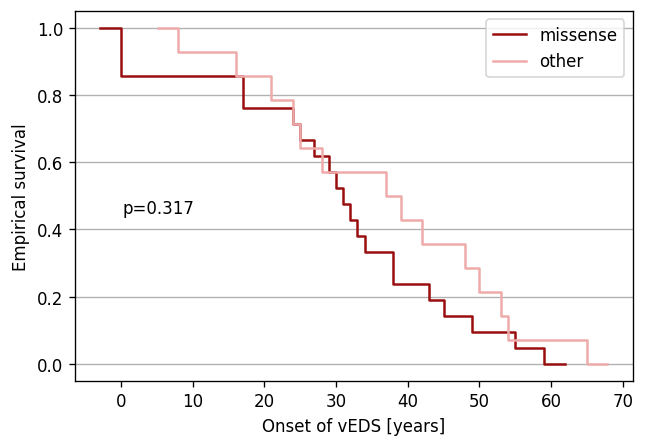

In [21]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from gpsea.model import Age

fig, ax = plt.subplots(figsize=(6, 4), dpi=120)
missense_survival_result.plot_kaplan_meier_curves(
    ax=ax,
)
_ = ax.xaxis.set(
    major_formatter=mpl.ticker.FuncFormatter(lambda x, pos: f"{x / Age.DAYS_IN_YEAR:.0f}"),
    major_locator=mpl.ticker.MultipleLocator(10 * Age.DAYS_IN_YEAR),
)
_ = ax.set(
    xlabel="Onset of vEDS [years]",
    ylabel="Empirical survival",
)
_ = ax.grid(axis="y")
_ = ax.text(100,0.45, f"p={missense_survival_result.pval:.3f}")

# Summary

In [22]:
from gpseacs.report import  GPAnalysisResultSummary, GpseaAnalysisReport

f_results =  (
 GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ), GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=triple_result,
    ), 
    GPAnalysisResultSummary.from_multi(
        result=dx_result,
    ), 
     GPAnalysisResultSummary.from_multi(
        result=is_gly_missense_result,
    ), 
)

m_results = (
    GPAnalysisResultSummary.from_mono(
        result=missense_survival_result
    ),
)

caption = "No significant GPC identified. Frank et al (2015) found that glycine missense variants were associated with a higher degree of severity in a cohort of 215 individuals. Primary data was not made available."

report = GpseaAnalysisReport(
    name=gene_symbol,
    cohort=cohort,
    fet_results=f_results,
    mono_results=m_results,
    gene_symbol=gene_symbol,
    mane_tx_id=mane_tx_id,
    mane_protein_id=mane_protein_id,
    caption=caption,
)

In [23]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

In [19]:
summarizer.process_latex(report=report, protein_fig=COL3A1_fig)

Figure saved to ../../supplement/img/COL3A1_protein_diagram-draft.pdf
Output to ../../supplement/tex/COL3A1_summary_draft.tex
